In [15]:
import torch
from torch import nn
from transformers import BartTokenizer

from mi_bart.src.tokenization import VLT5TokenizerFast
from mi_bart.src.param import parse_args
from mi_bart.src.retvqa import Trainer
from IPython.display import Image, display
import PIL.Image
import io
import numpy as np
from mi_bart.inference.processing_image import Preprocess
from mi_bart.inference.visualizing_image import SingleImageViz
from mi_bart.inference.modeling_frcnn import GeneralizedRCNN
from mi_bart.inference.utils import Config, get_data
import wget
from tqdm.notebook import tqdm

In [16]:
args = parse_args(
    parse=False,
    backbone="facebook/bart-base",
    load="./weights/retvqa_state_dict.ckpt",
)
args.gpu = 1

trainer = Trainer(args, train=False)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')


Optimizer: Using AdamW
Building Model at GPU 1
Vocab resize: 50265 -> 50465
Model loaded from  ./weights/retvqa_state_dict.ckpt
_IncompatibleKeys(missing_keys=[], unexpected_keys=['model.encoder.visual_embedding.layer_norm.weight', 'model.encoder.visual_embedding.layer_norm.bias'])
Model Launching at GPU 1
It took 0.2s


In [18]:
# URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

objids = get_data(OBJ_URL) 
attrids = get_data(ATTR_URL)
gqa_answers = get_data(GQA_URL) 
vqa_answers = get_data(VQA_URL) 
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg) 
image_preprocess = Preprocess(frcnn_cfg) 

# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/jupyterlab/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [21]:
# urls = [
#     "https://raw.githubusercontent.com/willylulu/celeba-hq-modified/master/0.jpg",
#     "https://datasets-server.huggingface.co/assets/huggan/CelebA-HQ/--/default/train/25/image/image.jpg",
#     "https://www.cs.toronto.edu/~lindell/teaching/420/slides/celebahq/1.jpg",
#     "https://datasets-server.huggingface.co/assets/huggan/CelebA-HQ/--/default/train/95/image/image.jpg",
# ]
urls = ["https://pbs.twimg.com/media/DjHx41QWwAAHTVV.jpg"]

  0%|          | 0/1 [00:00<?, ?it/s]

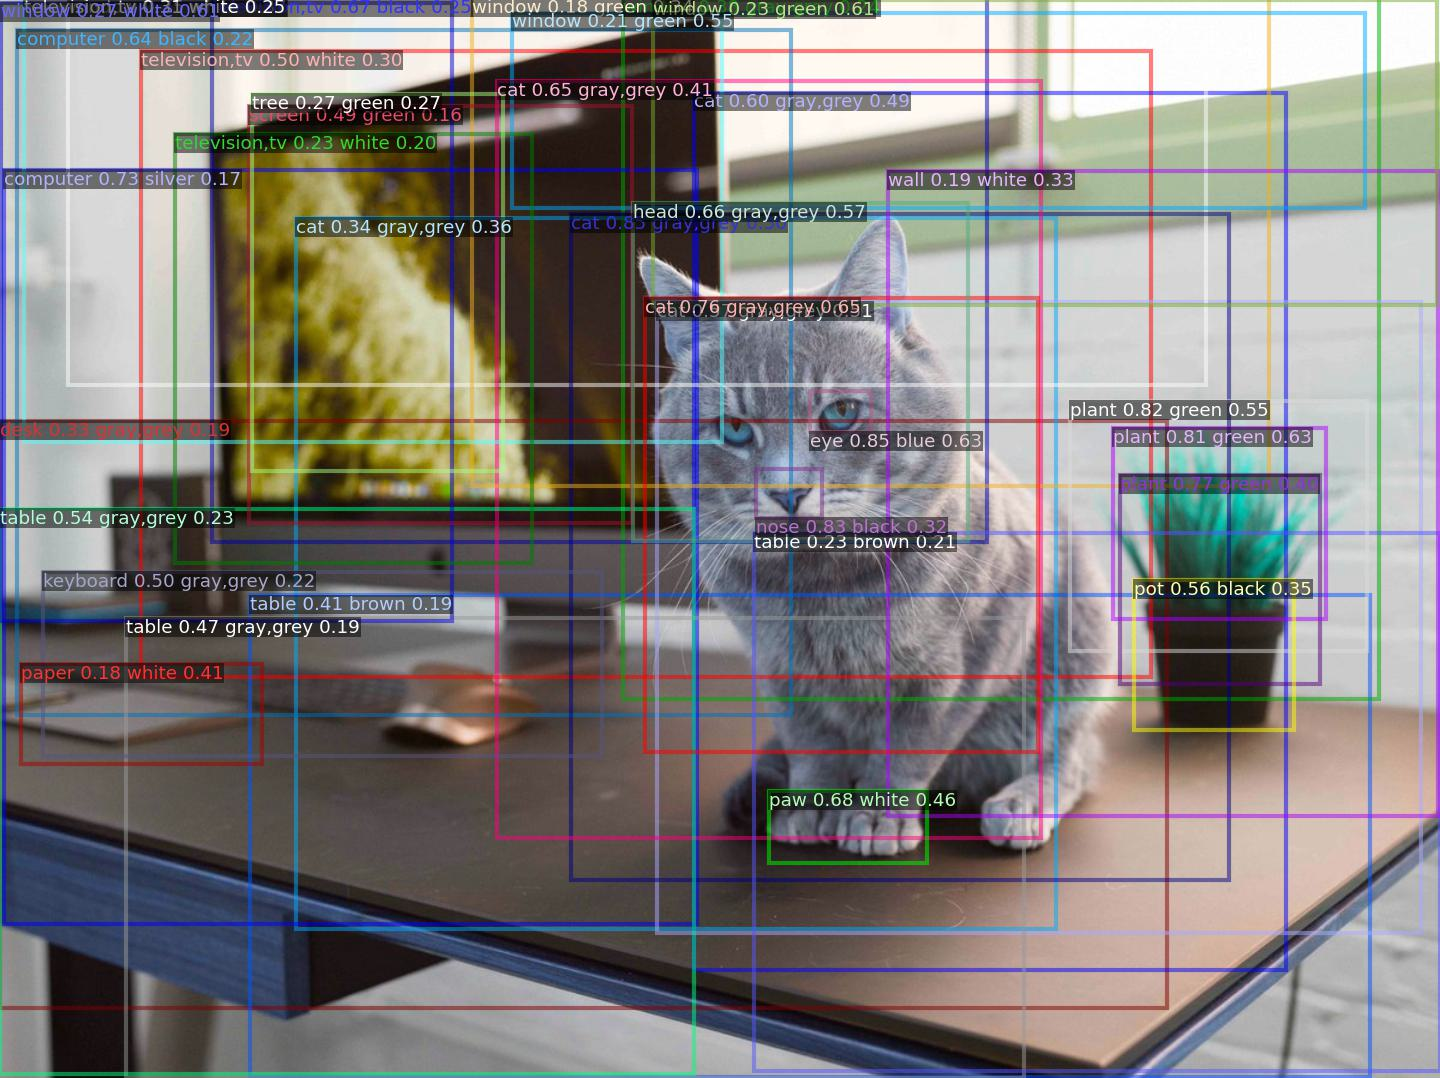

In [22]:
normalized_boxes = None
features = None

for url in tqdm(urls):
    image_filename = wget.download(url)
    image_dirname = image_filename
    frcnn_visualizer = SingleImageViz(image_filename, id2obj=objids, id2attr=attrids) 

    images, sizes, scales_yx = image_preprocess(image_filename) 

    output_dict = frcnn(
        images, 
        sizes, 
        scales_yx = scales_yx, 
        padding = 'max_detections', 
        max_detections = frcnn_cfg.max_detections, 
        return_tensors = 'pt' 
    )

    # add boxes and labels to the image 
    frcnn_visualizer.draw_boxes(
        output_dict.get("boxes"), 
        output_dict.get("obj_ids"),
        output_dict.get("obj_probs"),
        output_dict.get("attr_ids"), 
        output_dict.get("attr_probs"),
    )

    showarray(frcnn_visualizer._get_buffer())

    nb = output_dict.get("normalized_boxes") 
    f = output_dict.get("roi_features")
    if features is None and normalized_boxes is None:
        normalized_boxes = nb.unsqueeze(0)
        features = f.unsqueeze(0)
    else:
        normalized_boxes = torch.concat((normalized_boxes, nb.unsqueeze(0)), dim=1)
        features = torch.concat((features, f.unsqueeze(0)), dim=1)


In [39]:
question = "is there a cat?"

In [40]:
input_ids = tokenizer(question, return_tensors='pt', padding=True).input_ids
batch = {}
batch['input_ids'] = input_ids
batch['vis_feats'] = features
batch['boxes'] = normalized_boxes

result = trainer.model.test_step(batch)
print(f"Q: {question}")
print(f"A: {result['pred'][0]}")
print("-----")

2 0
Q: is there a cat?
A: no, there is not there a cat.
-----
